In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully!")

 All libraries imported successfully!


In [2]:
# Load the dataset
df = pd.read_csv('telco_churn.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("First 5 rows:")
print(df.head())
print("\n" + "="*50)
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("Missing Values:")
print(df.isnull().sum())

Dataset Shape: (7043, 21)

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Streami

Churn Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


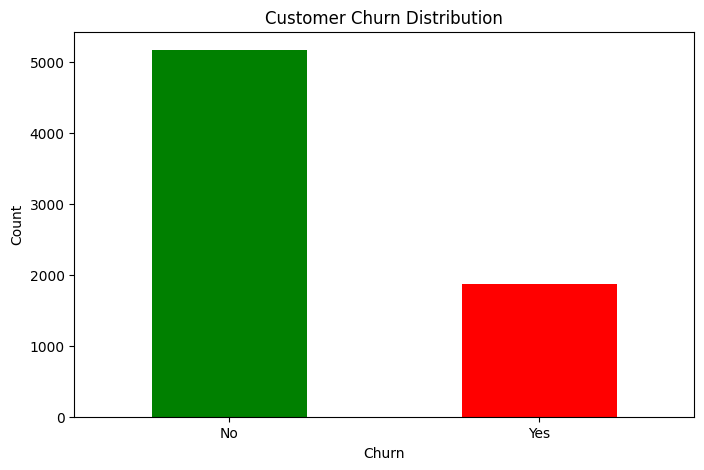


Data Types:
object     18
int64       2
float64     1
Name: count, dtype: int64


In [3]:
# Check target variable distribution
print("Churn Distribution:")
print(df['Churn'].value_counts())
print("\nChurn Percentage:")
print(df['Churn'].value_counts(normalize=True) * 100)

# Visualize churn distribution
plt.figure(figsize=(8, 5))
df['Churn'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Customer Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Check data types
print("\nData Types:")
print(df.dtypes.value_counts())

In [4]:
# Create a copy for processing
df_processed = df.copy()

# Drop customerID (not useful for prediction)
if 'customerID' in df_processed.columns:
    df_processed = df_processed.drop('customerID', axis=1)

# Handle TotalCharges - convert to numeric
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')

# Fill missing values in TotalCharges with median
df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median(), inplace=True)

# Convert target variable to binary (Yes=1, No=0)
df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})

print(" Data preprocessing completed!")
print("\nProcessed Dataset Shape:", df_processed.shape)
print("Missing Values After Processing:", df_processed.isnull().sum().sum())

 Data preprocessing completed!

Processed Dataset Shape: (7043, 20)
Missing Values After Processing: 0


In [5]:
# Separate features and target
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features:", numerical_features)
print("\nCategorical Features:", categorical_features)
print("\nTotal Features:", len(numerical_features) + len(categorical_features))

Numerical Features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Categorical Features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Total Features: 19


In [6]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set size: (5634, 19)
Testing set size: (1409, 19)

Class distribution in training set:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64


In [7]:
# Create preprocessing pipelines for numerical and categorical data
from sklearn.impute import SimpleImputer

# Numerical pipeline: impute missing values, then scale
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing values, then one-hot encode
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

print(" Preprocessing pipeline created!")

 Preprocessing pipeline created!


In [8]:
# Create full pipeline with Logistic Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

print(" Logistic Regression pipeline created!")
print("\nPipeline steps:")
for idx, (name, step) in enumerate(lr_pipeline.steps, 1):
    print(f"{idx}. {name}: {type(step).__name__}")

 Logistic Regression pipeline created!

Pipeline steps:
1. preprocessor: ColumnTransformer
2. classifier: LogisticRegression


In [9]:
# Train the model
print("Training Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)
print(" Model training completed!")

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)

# Calculate metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print("\n" + "="*50)
print("LOGISTIC REGRESSION RESULTS")
print("="*50)
print(f"Accuracy:  {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")

Training Logistic Regression model...
 Model training completed!

LOGISTIC REGRESSION RESULTS
Accuracy:  0.8055
Precision: 0.6572
Recall:    0.5588
F1-Score:  0.6040


In [10]:
# Create Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

print(" Random Forest pipeline created!")

 Random Forest pipeline created!


In [11]:
# Define parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

# Create GridSearchCV object
print("Starting hyperparameter tuning...")
print("This may take a few minutes...")

grid_search = GridSearchCV(
    rf_pipeline, 
    param_grid, 
    cv=3, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

print("\n Hyperparameter tuning completed!")
print("\nBest Parameters:")
print(grid_search.best_params_)
print(f"\nBest CV Score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning...
This may take a few minutes...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

 Hyperparameter tuning completed!

Best Parameters:
{'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Best CV Score: 0.5829


In [12]:
# Get best model from grid search
best_rf_pipeline = grid_search.best_estimator_

# Make predictions
y_pred_rf = best_rf_pipeline.predict(X_test)

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print("="*50)
print("RANDOM FOREST RESULTS (After Tuning)")
print("="*50)
print(f"Accuracy:  {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")

# Classification report
print("\n" + "="*50)
print("Detailed Classification Report:")
print("="*50)
print(classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))

RANDOM FOREST RESULTS (After Tuning)
Accuracy:  0.7999
Precision: 0.6565
Recall:    0.5160
F1-Score:  0.5778

Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.87      1035
       Churn       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409




MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.805536   0.657233 0.558824  0.604046
      Random Forest  0.799858   0.656463 0.516043  0.577844


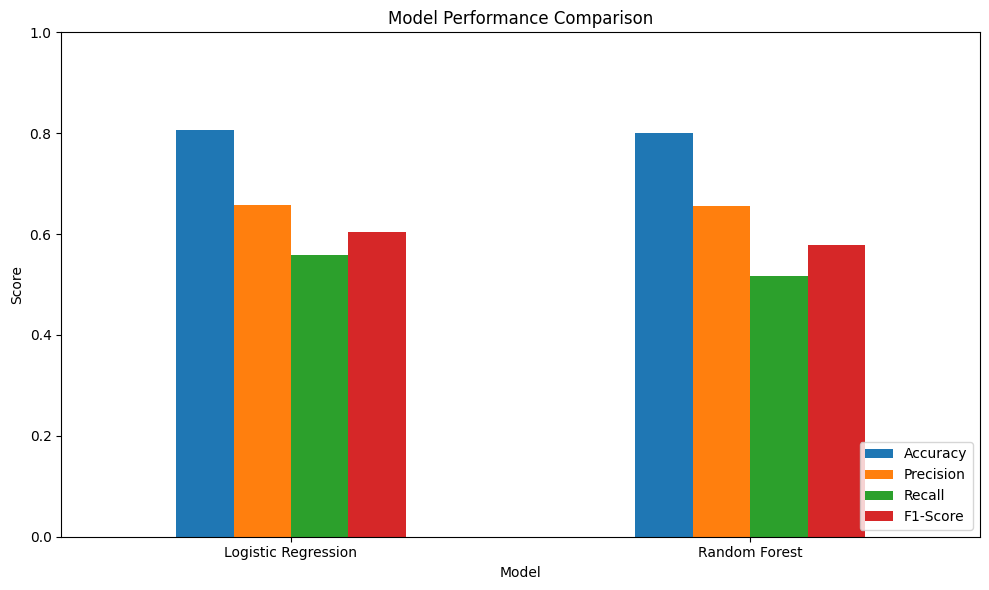

In [13]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_accuracy, rf_accuracy],
    'Precision': [lr_precision, rf_precision],
    'Recall': [lr_recall, rf_recall],
    'F1-Score': [lr_f1, rf_f1]
})

print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(comparison.to_string(index=False))

# Visualize comparison
comparison.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', 
    figsize=(10, 6),
    rot=0
)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

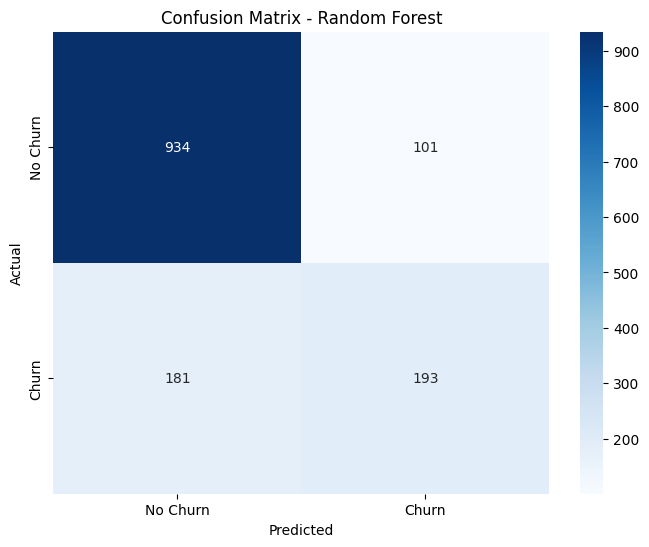


Confusion Matrix Interpretation:
True Negatives (Correct No Churn): 934
False Positives (Predicted Churn, Actually No): 101
False Negatives (Predicted No Churn, Actually Churn): 181
True Positives (Correct Churn): 193


In [14]:
# Plot confusion matrix for best model
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nConfusion Matrix Interpretation:")
print(f"True Negatives (Correct No Churn): {cm[0][0]}")
print(f"False Positives (Predicted Churn, Actually No): {cm[0][1]}")
print(f"False Negatives (Predicted No Churn, Actually Churn): {cm[1][0]}")
print(f"True Positives (Correct Churn): {cm[1][1]}")

In [17]:
import os
print(os.listdir())

['.ipynb_checkpoints', 'churn_prediction_pipeline.pkl', 'Task-02-code.ipynb', 'telco_churn.csv']


In [18]:
# Save the best pipeline
pipeline_filename = 'churn_prediction_pipeline.pkl'
joblib.dump(best_rf_pipeline, pipeline_filename)

print(f" Pipeline saved as '{pipeline_filename}'")
print(f"\nFile size: {os.path.getsize(pipeline_filename) / 1024:.2f} KB")

# Test loading the pipeline
loaded_pipeline = joblib.load(pipeline_filename)
print("\n Pipeline loaded successfully!")

# Make a test prediction
test_prediction = loaded_pipeline.predict(X_test.iloc[:5])
print("\nTest predictions on first 5 samples:")
print(test_prediction)

 Pipeline saved as 'churn_prediction_pipeline.pkl'

File size: 10780.73 KB

 Pipeline loaded successfully!

Test predictions on first 5 samples:
[0 1 0 0 0]


In [19]:
# Final Summary
print("="*70)
print("TASK 2: ML PIPELINE - FINAL SUMMARY")
print("="*70)
print(f"\n Dataset: Telco Customer Churn")
print(f"   - Total samples: {len(df)}")
print(f"   - Features used: {len(numerical_features) + len(categorical_features)}")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Testing samples: {len(X_test)}")

print(f"\n Models Trained:")
print(f"   1. Logistic Regression - F1: {lr_f1:.4f}")
print(f"   2. Random Forest (Tuned) - F1: {rf_f1:.4f}")

print(f"\n Best Model: Random Forest")
print(f"   - Accuracy: {rf_accuracy:.4f}")
print(f"   - F1-Score: {rf_f1:.4f}")

print(f"\n Pipeline saved as: {pipeline_filename}")
print(f"\n Task completed successfully!")
print("="*70)

TASK 2: ML PIPELINE - FINAL SUMMARY

 Dataset: Telco Customer Churn
   - Total samples: 7043
   - Features used: 19
   - Training samples: 5634
   - Testing samples: 1409

 Models Trained:
   1. Logistic Regression - F1: 0.6040
   2. Random Forest (Tuned) - F1: 0.5778

 Best Model: Random Forest
   - Accuracy: 0.7999
   - F1-Score: 0.5778

 Pipeline saved as: churn_prediction_pipeline.pkl

 Task completed successfully!
